In [2]:
import os
import numpy
import time
import glob
import random

from tqdm import tqdm
from jellyfish import levenshtein_distance
from tensorflow.keras.models import load_model

%matplotlib inline
from matplotlib import pyplot as plt

In [3]:
from buffer_generator import generate_data_image

In [4]:
from pipeline_v2 import Pipeline
pipeline = Pipeline()

Using TensorFlow backend.


In [5]:
def load_labels(label_dir):
    labels = []
    with open(label_dir) as f:
        labels = [label.rstrip() for label in f]
        
    return labels

In [6]:
def test_single_char_samples(model):
    model_numeric = load_model('models/{}.model'.format(model))
    
    x_test = numpy.load('tests/single_char_samples/x_test.npy')
    y_test = numpy.load('tests/single_char_samples/y_test.npy')
    
    x_test = x_test/255.0
    
    loss, accuracy = model_numeric.evaluate(x_test, y_test)
    print('Accuracy: {}%'.format(round(accuracy * 100, 2)))
    print('Loss: ', round(loss, 4))

In [7]:
def test_multi_char_samples(char_count, model, frameskip, verbose=False):
    directory = 'tests/multi_char_samples/{}/'.format(char_count)
    label_dir = directory + 'labels'
    labels = load_labels(label_dir)
    
    total_time = 0
    total_samples = len(glob.glob1(directory,'*.npy'))
    
    bi_score = 0
    bi_true = 0
    bi_false = []
    
    fwd_score = 0
    fwd_true = 0
    fwd_false = []
    
    for file in tqdm(os.listdir(directory)):
        if file.endswith('.npy'):
            file_dir = os.path.join(directory, file)
            file_label = labels[int(file.split('.')[0].split('_')[0])]
            pts = numpy.load(file_dir)
            
            start_time = time.time()
            bi, fwd, _ = pipeline.predict_data(pts, model, frameskip)
            elapsed_time = time.time() - start_time
            total_time += elapsed_time
            
            #Calculating Levenshtein Distance for Accuracy Measurement
            bi = ''.join([str(i) for i in bi])
            bi_ld = levenshtein_distance(bi, file_label)
            maxlen = len(bi) if len(bi) > len(file_label) else len(file_label)
            bi_score += ((maxlen - bi_ld)/maxlen)
            
            fwd = ''.join([str(i) for i in fwd])
            fwd_ld = levenshtein_distance(fwd, file_label)
            maxlen = len(fwd) if len(fwd) > len(file_label) else len(file_label)
            fwd_score += ((maxlen - fwd_ld)/maxlen)
            
            if bi == file_label:
                bi_true += 1
            else:
                bi_false.append({'File': file, 'Actual': file_label, 'Predicted': bi, 'Score': bi_ld})
            
            if fwd == file_label:
                fwd_true += 1
            else:
                fwd_false.append({'File': file, 'Actual': file_label, 'Predicted': fwd, 'Score': fwd_ld})
    
    time_per_sample = total_time/total_samples
    bi_acc = round((bi_score/total_samples) * 100, 2)
    fwd_acc = round((fwd_score/total_samples) * 100, 2)
    
    #Displaying Results
    print('-----------------------------------')
    print('RESULTS: {} Character || Model {}'.format(char_count, model))
    print('-----------------------------------')
    print('Total Samples: ', total_samples)
    print('Forward Accuracy: {}%'.format(fwd_acc))
    print('Forward True: ', fwd_true)
    print('Bi-directional Accuracy: {}%'.format(bi_acc))
    print('Bi-directional True: ', bi_true)
    print('Total Time: {}s'.format(round(total_time, 2)))
    print('Time Per Sample: {}s'.format(round(time_per_sample, 2)))
    
    if verbose:
        f1, f2, f3, f4, b1, b2, b3, b4 = 0, 0, 0, 0, 0, 0, 0, 0
        
        print('')
        print('-----------------------------------')
        print('ERROR ANALYSIS')
        print('-----------------------------------')
        
        print('')
        print('Forward Scan Errors')
        print('-----------------------------------')
        for i in fwd_false:
            f, a, p, s = i['File'], i['Actual'], i['Predicted'], i['Score']
            
            if s == 1:
                f1 += 1
            elif s == 2:
                f2 += 1
            elif s == 3:
                f3 += 1
            elif s >= 4:
                f4 += 1
            
            print('File: {}\t\tActual: {}\tPredicted: {}\tScore: {}'.format(f, a, p, s))
        print('-----------------------------------')
        print('L-Distance => 1: {}\t2: {}\t3: {}\t4+: {}'.format(f1, f2, f3, f4))
        
        print('')
        print('Bi-directional Scan Errors')
        print('-----------------------------------')
        for i in bi_false:
            f, a, p, s = i['File'], i['Actual'], i['Predicted'], i['Score']
            
            if s == 1:
                b1 += 1
            elif s == 2:
                b2 += 1
            elif s == 3:
                b3 += 1
            elif s >= 4:
                b4 += 1
            
            print('File: {}\t\tActual: {}\tPredicted: {}\tScore: {}'.format(f, a, p, s))
        print('-----------------------------------')
        print('L-Distance => 1: {}\t2: {}\t3: {}\t4+: {}'.format(b1, b2, b3, b4))

In [8]:
def display_samples(char_count, columns=5, rows=2):
    directory = 'tests/multi_char_samples/{}/'.format(char_count)
    disp_samples = rows * columns
    samples = []
    while len(samples) < disp_samples:
        smp = random.choice(os.listdir(directory))
        if smp.endswith('.npy') and smp not in samples:
            samples.append(smp)

    plt.figure(figsize=(20, 10))
    for i, smp in enumerate(samples):
        plt.subplot(disp_samples/columns, columns, i + 1)
        pts = numpy.load(os.path.join(directory, smp))
        img = generate_data_image(pts)
        plt.imshow(img)
        plt.title(smp)

<h1>Experimentation Tests</h1>
<h2>1. Single Character Tests</h2>

In [8]:
test_single_char_samples('TS-A')

2000/2000 [==============================] - 1s 744us/sample - loss: 0.6558 - acc: 0.9140
Accuracy: 91.4%
Loss:  0.6558


In [9]:
test_single_char_samples('TS-B')

2000/2000 [==============================] - 2s 846us/sample - loss: 0.2252 - acc: 0.9375
Accuracy: 93.75%
Loss:  0.2252


In [10]:
test_single_char_samples('TS-C')

2000/2000 [==============================] - 2s 760us/sample - loss: 0.1243 - acc: 0.9640
Accuracy: 96.4%
Loss:  0.1243


In [11]:
test_single_char_samples('TS-D')

2000/2000 [==============================] - 2s 871us/sample - loss: 0.0478 - acc: 0.9875
Accuracy: 98.75%
Loss:  0.0478


<h2>2. Multi Character Tests</h2>
<h3>2 Character Samples</h3>

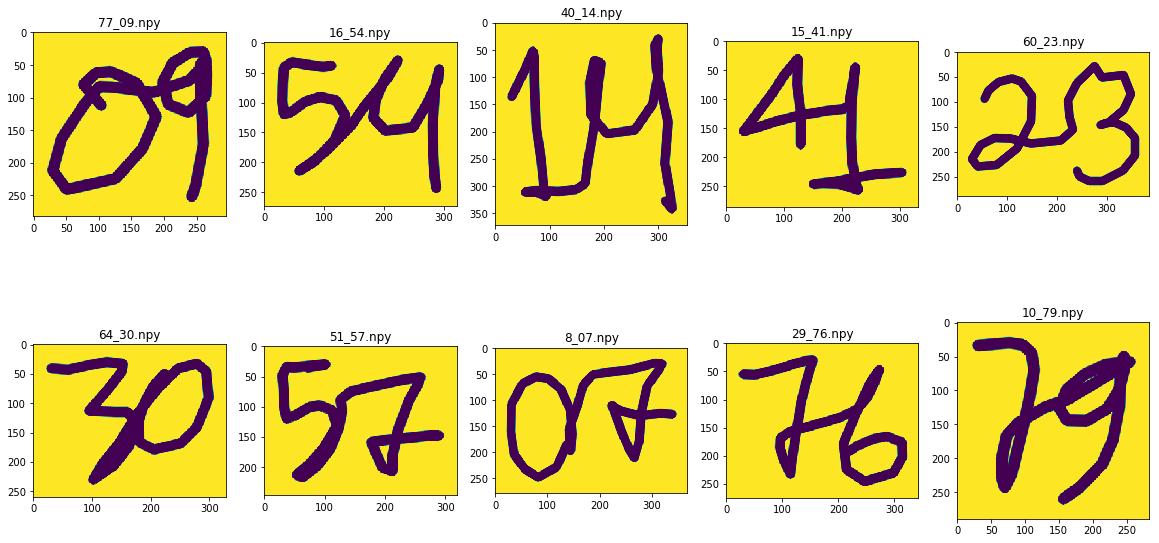

In [12]:
display_samples(2)

In [13]:
test_multi_char_samples(2, 'TS-A', frameskip=4, verbose=True)

100%|██████████| 101/101 [01:39<00:00,  1.28it/s]

-----------------------------------
RESULTS: 2 Character || Model TS-A
-----------------------------------
Total Samples:  100
Forward Accuracy: 66.0%
Forward True:  42
Bi-directional Accuracy: 78.0%
Bi-directional True:  60
Total Time: 99.89s
Time Per Sample: 1.0s

-----------------------------------
ERROR ANALYSIS
-----------------------------------

Forward Scan Errors
-----------------------------------
File: 57_06.npy		Actual: 06	Predicted: 08	Score: 1
File: 94_34.npy		Actual: 34	Predicted: 30	Score: 1
File: 27_81.npy		Actual: 81	Predicted: 8	Score: 1
File: 34_13.npy		Actual: 13	Predicted: 3	Score: 1
File: 37_64.npy		Actual: 64	Predicted: 8	Score: 2
File: 8_07.npy		Actual: 07	Predicted: 0	Score: 1
File: 19_62.npy		Actual: 62	Predicted: 82	Score: 1
File: 35_17.npy		Actual: 17	Predicted: 1	Score: 1
File: 33_29.npy		Actual: 29	Predicted: 3	Score: 2
File: 0_43.npy		Actual: 43	Predicted: 48	Score: 1
File: 71_21.npy		Actual: 21	Predicted: 23	Score: 1
File: 10_79.npy		Actual: 79	Predicte

In [14]:
test_multi_char_samples(2, 'TS-B', frameskip=4, verbose=True)

100%|██████████| 101/101 [01:36<00:00,  1.53it/s]

-----------------------------------
RESULTS: 2 Character || Model TS-B
-----------------------------------
Total Samples:  100
Forward Accuracy: 80.5%
Forward True:  67
Bi-directional Accuracy: 91.17%
Bi-directional True:  84
Total Time: 96.3s
Time Per Sample: 0.96s

-----------------------------------
ERROR ANALYSIS
-----------------------------------

Forward Scan Errors
-----------------------------------
File: 27_81.npy		Actual: 81	Predicted: 8	Score: 1
File: 34_13.npy		Actual: 13	Predicted: 8	Score: 2
File: 35_17.npy		Actual: 17	Predicted: 5	Score: 2
File: 33_29.npy		Actual: 29	Predicted: 9	Score: 1
File: 0_43.npy		Actual: 43	Predicted: 48	Score: 1
File: 85_42.npy		Actual: 42	Predicted: 4	Score: 1
File: 54_78.npy		Actual: 78	Predicted: 7	Score: 1
File: 42_35.npy		Actual: 35	Predicted: 5	Score: 1
File: 76_87.npy		Actual: 87	Predicted: 81	Score: 1
File: 53_12.npy		Actual: 12	Predicted: 8	Score: 2
File: 58_00.npy		Actual: 00	Predicted: 0	Score: 1
File: 75_86.npy		Actual: 86	Predicted

In [15]:
test_multi_char_samples(2, 'TS-C', frameskip=4, verbose=True)

100%|██████████| 101/101 [01:31<00:00,  1.46it/s]

-----------------------------------
RESULTS: 2 Character || Model TS-C
-----------------------------------
Total Samples:  100
Forward Accuracy: 82.0%
Forward True:  67
Bi-directional Accuracy: 93.0%
Bi-directional True:  87
Total Time: 91.37s
Time Per Sample: 0.91s

-----------------------------------
ERROR ANALYSIS
-----------------------------------

Forward Scan Errors
-----------------------------------
File: 94_34.npy		Actual: 34	Predicted: 30	Score: 1
File: 27_81.npy		Actual: 81	Predicted: 8	Score: 1
File: 31_95.npy		Actual: 95	Predicted: 96	Score: 1
File: 35_17.npy		Actual: 17	Predicted: 1	Score: 1
File: 33_29.npy		Actual: 29	Predicted: 9	Score: 1
File: 0_43.npy		Actual: 43	Predicted: 4	Score: 1
File: 71_21.npy		Actual: 21	Predicted: 4	Score: 2
File: 10_79.npy		Actual: 79	Predicted: 89	Score: 1
File: 85_42.npy		Actual: 42	Predicted: 4	Score: 1
File: 54_78.npy		Actual: 78	Predicted: 7	Score: 1
File: 62_47.npy		Actual: 47	Predicted: 9	Score: 2
File: 42_35.npy		Actual: 35	Predicte

In [16]:
test_multi_char_samples(2, 'TS-D', frameskip=4, verbose=True)

100%|██████████| 101/101 [01:26<00:00,  1.61it/s]

-----------------------------------
RESULTS: 2 Character || Model TS-D
-----------------------------------
Total Samples:  100
Forward Accuracy: 84.5%
Forward True:  69
Bi-directional Accuracy: 96.0%
Bi-directional True:  92
Total Time: 86.42s
Time Per Sample: 0.86s

-----------------------------------
ERROR ANALYSIS
-----------------------------------

Forward Scan Errors
-----------------------------------
File: 94_34.npy		Actual: 34	Predicted: 30	Score: 1
File: 27_81.npy		Actual: 81	Predicted: 8	Score: 1
File: 31_95.npy		Actual: 95	Predicted: 94	Score: 1
File: 35_17.npy		Actual: 17	Predicted: 1	Score: 1
File: 33_29.npy		Actual: 29	Predicted: 9	Score: 1
File: 0_43.npy		Actual: 43	Predicted: 4	Score: 1
File: 85_42.npy		Actual: 42	Predicted: 4	Score: 1
File: 25_46.npy		Actual: 46	Predicted: 6	Score: 1
File: 6_55.npy		Actual: 55	Predicted: 58	Score: 1
File: 58_00.npy		Actual: 00	Predicted: 0	Score: 1
File: 75_86.npy		Actual: 86	Predicted: 8	Score: 1
File: 50_22.npy		Actual: 22	Predicted

<h3>3 Character Samples</h3>

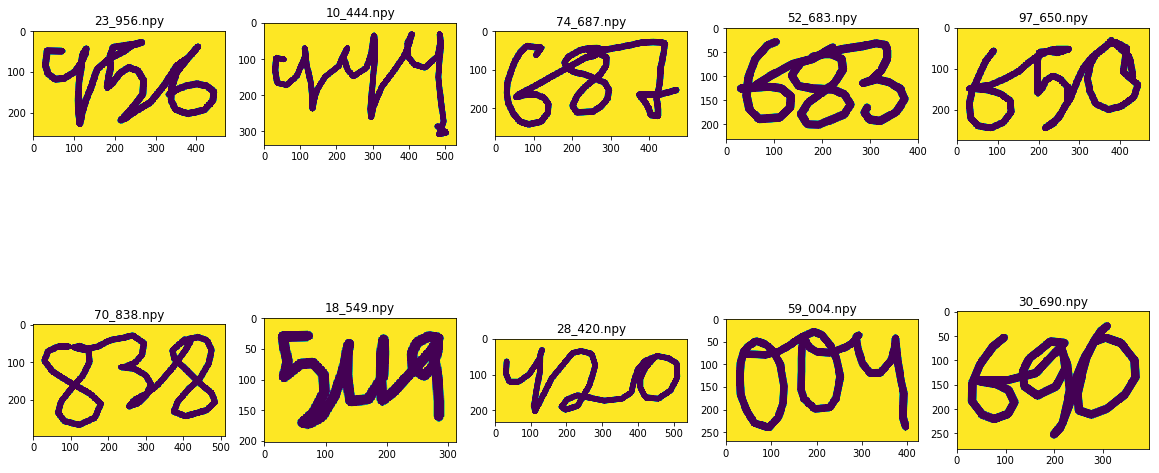

In [17]:
display_samples(3)

In [18]:
test_multi_char_samples(3, 'TS-A', frameskip=4, verbose=True)

100%|██████████| 101/101 [03:25<00:00,  1.59s/it]

-----------------------------------
RESULTS: 3 Character || Model TS-A
-----------------------------------
Total Samples:  100
Forward Accuracy: 66.5%
Forward True:  32
Bi-directional Accuracy: 73.17%
Bi-directional True:  34
Total Time: 205.07s
Time Per Sample: 2.05s

-----------------------------------
ERROR ANALYSIS
-----------------------------------

Forward Scan Errors
-----------------------------------
File: 20_316.npy		Actual: 316	Predicted: 31	Score: 1
File: 86_689.npy		Actual: 689	Predicted: 889	Score: 1
File: 3_751.npy		Actual: 751	Predicted: 81	Score: 2
File: 74_687.npy		Actual: 687	Predicted: 68	Score: 1
File: 24_494.npy		Actual: 494	Predicted: 490	Score: 1
File: 13_123.npy		Actual: 123	Predicted: 5	Score: 3
File: 36_888.npy		Actual: 888	Predicted: 9288	Score: 2
File: 84_675.npy		Actual: 675	Predicted: 65	Score: 1
File: 93_323.npy		Actual: 323	Predicted: 32	Score: 1
File: 0_873.npy		Actual: 873	Predicted: 883	Score: 1
File: 17_798.npy		Actual: 798	Predicted: 38	Score: 2
F

In [19]:
test_multi_char_samples(3, 'TS-B', frameskip=4, verbose=True)

100%|██████████| 101/101 [03:08<00:00,  1.87s/it]

-----------------------------------
RESULTS: 3 Character || Model TS-B
-----------------------------------
Total Samples:  100
Forward Accuracy: 76.0%
Forward True:  47
Bi-directional Accuracy: 83.0%
Bi-directional True:  57
Total Time: 188.26s
Time Per Sample: 1.88s

-----------------------------------
ERROR ANALYSIS
-----------------------------------

Forward Scan Errors
-----------------------------------
File: 86_689.npy		Actual: 689	Predicted: 889	Score: 1
File: 3_751.npy		Actual: 751	Predicted: 8	Score: 3
File: 74_687.npy		Actual: 687	Predicted: 65	Score: 2
File: 24_494.npy		Actual: 494	Predicted: 491	Score: 1
File: 13_123.npy		Actual: 123	Predicted: 12	Score: 1
File: 36_888.npy		Actual: 888	Predicted: 882	Score: 1
File: 84_675.npy		Actual: 675	Predicted: 65	Score: 1
File: 93_323.npy		Actual: 323	Predicted: 32	Score: 1
File: 2_989.npy		Actual: 989	Predicted: 987	Score: 1
File: 17_798.npy		Actual: 798	Predicted: 738	Score: 1
File: 64_723.npy		Actual: 723	Predicted: 7	Score: 2
Fil

In [20]:
test_multi_char_samples(3, 'TS-C', frameskip=4, verbose=True)

100%|██████████| 101/101 [03:00<00:00,  1.70s/it]

-----------------------------------
RESULTS: 3 Character || Model TS-C
-----------------------------------
Total Samples:  100
Forward Accuracy: 77.33%
Forward True:  48
Bi-directional Accuracy: 83.17%
Bi-directional True:  53
Total Time: 180.51s
Time Per Sample: 1.81s

-----------------------------------
ERROR ANALYSIS
-----------------------------------

Forward Scan Errors
-----------------------------------
File: 86_689.npy		Actual: 689	Predicted: 68	Score: 1
File: 3_751.npy		Actual: 751	Predicted: 9	Score: 3
File: 74_687.npy		Actual: 687	Predicted: 65	Score: 2
File: 24_494.npy		Actual: 494	Predicted: 490	Score: 1
File: 13_123.npy		Actual: 123	Predicted: 12	Score: 1
File: 36_888.npy		Actual: 888	Predicted: 883	Score: 1
File: 84_675.npy		Actual: 675	Predicted: 65	Score: 1
File: 93_323.npy		Actual: 323	Predicted: 363	Score: 1
File: 2_989.npy		Actual: 989	Predicted: 986	Score: 1
File: 17_798.npy		Actual: 798	Predicted: 738	Score: 1
File: 23_956.npy		Actual: 956	Predicted: 56	Score: 1


In [21]:
test_multi_char_samples(3, 'TS-D', frameskip=4, verbose=True)

100%|██████████| 101/101 [02:50<00:00,  1.71s/it]

-----------------------------------
RESULTS: 3 Character || Model TS-D
-----------------------------------
Total Samples:  100
Forward Accuracy: 82.0%
Forward True:  55
Bi-directional Accuracy: 83.0%
Bi-directional True:  51
Total Time: 170.48s
Time Per Sample: 1.7s

-----------------------------------
ERROR ANALYSIS
-----------------------------------

Forward Scan Errors
-----------------------------------
File: 86_689.npy		Actual: 689	Predicted: 886	Score: 2
File: 3_751.npy		Actual: 751	Predicted: 8	Score: 3
File: 24_494.npy		Actual: 494	Predicted: 90	Score: 2
File: 13_123.npy		Actual: 123	Predicted: 12	Score: 1
File: 36_888.npy		Actual: 888	Predicted: 883	Score: 1
File: 84_675.npy		Actual: 675	Predicted: 65	Score: 1
File: 93_323.npy		Actual: 323	Predicted: 32	Score: 1
File: 17_798.npy		Actual: 798	Predicted: 738	Score: 1
File: 23_956.npy		Actual: 956	Predicted: 456	Score: 1
File: 38_905.npy		Actual: 905	Predicted: 903	Score: 1
File: 33_794.npy		Actual: 794	Predicted: 744	Score: 1
F

<h3>4 Character Samples</h3>

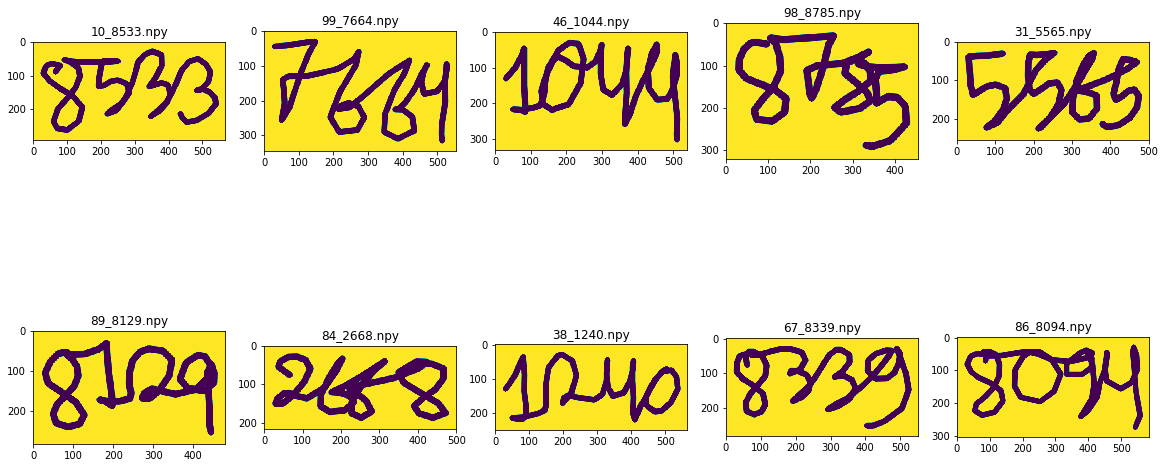

In [22]:
display_samples(4)

In [23]:
test_multi_char_samples(4, 'TS-A', frameskip=4, verbose=True)

100%|██████████| 101/101 [04:43<00:00,  2.64s/it]

-----------------------------------
RESULTS: 4 Character || Model TS-A
-----------------------------------
Total Samples:  100
Forward Accuracy: 60.5%
Forward True:  14
Bi-directional Accuracy: 71.4%
Bi-directional True:  23
Total Time: 283.72s
Time Per Sample: 2.84s

-----------------------------------
ERROR ANALYSIS
-----------------------------------

Forward Scan Errors
-----------------------------------
File: 59_1810.npy		Actual: 1810	Predicted: 80	Score: 2
File: 49_6955.npy		Actual: 6955	Predicted: 95	Score: 2
File: 93_5787.npy		Actual: 5787	Predicted: 767	Score: 2
File: 81_8806.npy		Actual: 8806	Predicted: 830	Score: 2
File: 41_4071.npy		Actual: 4071	Predicted: 01	Score: 2
File: 63_8345.npy		Actual: 8345	Predicted: 835	Score: 1
File: 37_8385.npy		Actual: 8385	Predicted: 838	Score: 1
File: 46_1044.npy		Actual: 1044	Predicted: 044	Score: 1
File: 21_4332.npy		Actual: 4332	Predicted: 473	Score: 2
File: 9_7229.npy		Actual: 7229	Predicted: 29	Score: 2
File: 16_8914.npy		Actual: 8914	

In [24]:
test_multi_char_samples(4, 'TS-B', frameskip=4, verbose=True)

100%|██████████| 101/101 [04:45<00:00,  2.74s/it]

-----------------------------------
RESULTS: 4 Character || Model TS-B
-----------------------------------
Total Samples:  100
Forward Accuracy: 67.85%
Forward True:  28
Bi-directional Accuracy: 77.35%
Bi-directional True:  38
Total Time: 285.65s
Time Per Sample: 2.86s

-----------------------------------
ERROR ANALYSIS
-----------------------------------

Forward Scan Errors
-----------------------------------
File: 59_1810.npy		Actual: 1810	Predicted: 80	Score: 2
File: 49_6955.npy		Actual: 6955	Predicted: 95	Score: 2
File: 93_5787.npy		Actual: 5787	Predicted: 578	Score: 1
File: 81_8806.npy		Actual: 8806	Predicted: 8750	Score: 3
File: 41_4071.npy		Actual: 4071	Predicted: 7	Score: 3
File: 21_4332.npy		Actual: 4332	Predicted: 473	Score: 2
File: 9_7229.npy		Actual: 7229	Predicted: 729	Score: 1
File: 16_8914.npy		Actual: 8914	Predicted: 894	Score: 1
File: 72_1129.npy		Actual: 1129	Predicted: 9	Score: 3
File: 67_8339.npy		Actual: 8339	Predicted: 839	Score: 1
File: 50_5256.npy		Actual: 5256

In [25]:
test_multi_char_samples(4, 'TS-C', frameskip=4, verbose=True)

100%|██████████| 101/101 [04:22<00:00,  2.39s/it]

-----------------------------------
RESULTS: 4 Character || Model TS-C
-----------------------------------
Total Samples:  100
Forward Accuracy: 67.6%
Forward True:  24
Bi-directional Accuracy: 79.65%
Bi-directional True:  43
Total Time: 262.22s
Time Per Sample: 2.62s

-----------------------------------
ERROR ANALYSIS
-----------------------------------

Forward Scan Errors
-----------------------------------
File: 59_1810.npy		Actual: 1810	Predicted: 60	Score: 3
File: 49_6955.npy		Actual: 6955	Predicted: 6975	Score: 1
File: 93_5787.npy		Actual: 5787	Predicted: 58	Score: 2
File: 81_8806.npy		Actual: 8806	Predicted: 8750	Score: 3
File: 41_4071.npy		Actual: 4071	Predicted: 7	Score: 3
File: 63_8345.npy		Actual: 8345	Predicted: 835	Score: 1
File: 69_0098.npy		Actual: 0098	Predicted: 0096	Score: 1
File: 21_4332.npy		Actual: 4332	Predicted: 473	Score: 2
File: 9_7229.npy		Actual: 7229	Predicted: 769	Score: 2
File: 16_8914.npy		Actual: 8914	Predicted: 890	Score: 2
File: 72_1129.npy		Actual: 1

In [26]:
test_multi_char_samples(4, 'TS-D', frameskip=4, verbose=True)

100%|██████████| 101/101 [04:08<00:00,  2.09s/it]

-----------------------------------
RESULTS: 4 Character || Model TS-D
-----------------------------------
Total Samples:  100
Forward Accuracy: 71.75%
Forward True:  33
Bi-directional Accuracy: 81.6%
Bi-directional True:  49
Total Time: 248.78s
Time Per Sample: 2.49s

-----------------------------------
ERROR ANALYSIS
-----------------------------------

Forward Scan Errors
-----------------------------------
File: 59_1810.npy		Actual: 1810	Predicted: 60	Score: 3
File: 81_8806.npy		Actual: 8806	Predicted: 8750	Score: 3
File: 41_4071.npy		Actual: 4071	Predicted: 07	Score: 2
File: 46_1044.npy		Actual: 1044	Predicted: 1040	Score: 1
File: 9_7229.npy		Actual: 7229	Predicted: 29	Score: 2
File: 16_8914.npy		Actual: 8914	Predicted: 890	Score: 2
File: 72_1129.npy		Actual: 1129	Predicted: 229	Score: 2
File: 50_5256.npy		Actual: 5256	Predicted: 52	Score: 2
File: 7_5745.npy		Actual: 5745	Predicted: 5945	Score: 1
File: 99_7664.npy		Actual: 7664	Predicted: 784	Score: 2
File: 22_2487.npy		Actual: 24

<h2>3. Frameskip Tests</h2>
<h3>Frameskip = 1</h3>

In [27]:
test_multi_char_samples(2, 'TS-D', frameskip=1, verbose=False)

100%|██████████| 101/101 [03:25<00:00,  1.52s/it]

-----------------------------------
RESULTS: 2 Character || Model TS-D
-----------------------------------
Total Samples:  100
Forward Accuracy: 87.0%
Forward True:  75
Bi-directional Accuracy: 95.0%
Bi-directional True:  91
Total Time: 205.61s
Time Per Sample: 2.06s


In [28]:
test_multi_char_samples(3, 'TS-D', frameskip=1, verbose=False)

100%|██████████| 101/101 [07:08<00:00,  4.10s/it]

-----------------------------------
RESULTS: 3 Character || Model TS-D
-----------------------------------
Total Samples:  100
Forward Accuracy: 82.67%
Forward True:  55
Bi-directional Accuracy: 78.33%
Bi-directional True:  38
Total Time: 428.54s
Time Per Sample: 4.29s


In [29]:
test_multi_char_samples(4, 'TS-D', frameskip=1, verbose=False)

100%|██████████| 101/101 [10:57<00:00,  6.91s/it]

-----------------------------------
RESULTS: 4 Character || Model TS-D
-----------------------------------
Total Samples:  100
Forward Accuracy: 75.5%
Forward True:  37
Bi-directional Accuracy: 82.25%
Bi-directional True:  52
Total Time: 657.18s
Time Per Sample: 6.57s


<h3>Frameskip = 2</h3>

In [30]:
test_multi_char_samples(2, 'TS-D', frameskip=2, verbose=False)

100%|██████████| 101/101 [02:07<00:00,  1.11it/s]

-----------------------------------
RESULTS: 2 Character || Model TS-D
-----------------------------------
Total Samples:  100
Forward Accuracy: 87.0%
Forward True:  75
Bi-directional Accuracy: 95.5%
Bi-directional True:  92
Total Time: 127.06s
Time Per Sample: 1.27s


In [31]:
test_multi_char_samples(3, 'TS-D', frameskip=2, verbose=False)

100%|██████████| 101/101 [04:04<00:00,  2.40s/it]

-----------------------------------
RESULTS: 3 Character || Model TS-D
-----------------------------------
Total Samples:  100
Forward Accuracy: 82.83%
Forward True:  54
Bi-directional Accuracy: 82.0%
Bi-directional True:  47
Total Time: 244.16s
Time Per Sample: 2.44s


In [32]:
test_multi_char_samples(4, 'TS-D', frameskip=2, verbose=False)

100%|██████████| 101/101 [05:43<00:00,  3.47s/it]

-----------------------------------
RESULTS: 4 Character || Model TS-D
-----------------------------------
Total Samples:  100
Forward Accuracy: 73.25%
Forward True:  36
Bi-directional Accuracy: 81.5%
Bi-directional True:  51
Total Time: 343.91s
Time Per Sample: 3.44s


<h3>Frameskip = 4</h3>

In [33]:
test_multi_char_samples(2, 'TS-D', frameskip=4, verbose=False)

100%|██████████| 101/101 [01:18<00:00,  1.50it/s]

-----------------------------------
RESULTS: 2 Character || Model TS-D
-----------------------------------
Total Samples:  100
Forward Accuracy: 84.5%
Forward True:  69
Bi-directional Accuracy: 96.0%
Bi-directional True:  92
Total Time: 78.4s
Time Per Sample: 0.78s


In [34]:
test_multi_char_samples(3, 'TS-D', frameskip=4, verbose=False)

100%|██████████| 101/101 [02:38<00:00,  1.64s/it]

-----------------------------------
RESULTS: 3 Character || Model TS-D
-----------------------------------
Total Samples:  100
Forward Accuracy: 82.0%
Forward True:  55
Bi-directional Accuracy: 83.0%
Bi-directional True:  51
Total Time: 158.4s
Time Per Sample: 1.58s


In [35]:
test_multi_char_samples(4, 'TS-D', frameskip=4, verbose=False)

100%|██████████| 101/101 [03:55<00:00,  2.06s/it]

-----------------------------------
RESULTS: 4 Character || Model TS-D
-----------------------------------
Total Samples:  100
Forward Accuracy: 71.75%
Forward True:  33
Bi-directional Accuracy: 81.6%
Bi-directional True:  49
Total Time: 235.38s
Time Per Sample: 2.35s


<h3>Frameskip = 8</h3>

In [39]:
test_multi_char_samples(2, 'TS-D', frameskip=8, verbose=False)

100%|██████████| 101/101 [01:12<00:00,  1.76it/s]

-----------------------------------
RESULTS: 2 Character || Model TS-D
-----------------------------------
Total Samples:  100
Forward Accuracy: 77.5%
Forward True:  59
Bi-directional Accuracy: 88.83%
Bi-directional True:  78
Total Time: 72.65s
Time Per Sample: 0.73s


In [40]:
test_multi_char_samples(3, 'TS-D', frameskip=8, verbose=False)

100%|██████████| 101/101 [02:23<00:00,  2.20s/it]

-----------------------------------
RESULTS: 3 Character || Model TS-D
-----------------------------------
Total Samples:  100
Forward Accuracy: 71.67%
Forward True:  36
Bi-directional Accuracy: 77.1%
Bi-directional True:  43
Total Time: 143.33s
Time Per Sample: 1.43s


In [41]:
test_multi_char_samples(4, 'TS-D', frameskip=8, verbose=False)

100%|██████████| 101/101 [03:18<00:00,  2.39s/it]

-----------------------------------
RESULTS: 4 Character || Model TS-D
-----------------------------------
Total Samples:  100
Forward Accuracy: 67.5%
Forward True:  26
Bi-directional Accuracy: 76.65%
Bi-directional True:  39
Total Time: 198.27s
Time Per Sample: 1.98s


<h3>Frameskip = 12</h3>

In [9]:
test_multi_char_samples(2, 'TS-D', frameskip=12, verbose=False)

100%|██████████| 101/101 [00:58<00:00,  2.03it/s]

-----------------------------------
RESULTS: 2 Character || Model TS-D
-----------------------------------
Total Samples:  100
Forward Accuracy: 72.5%
Forward True:  51
Bi-directional Accuracy: 81.5%
Bi-directional True:  64
Total Time: 58.39s
Time Per Sample: 0.58s


In [10]:
test_multi_char_samples(3, 'TS-D', frameskip=12, verbose=False)

100%|██████████| 101/101 [02:13<00:00,  1.36s/it]

-----------------------------------
RESULTS: 3 Character || Model TS-D
-----------------------------------
Total Samples:  100
Forward Accuracy: 63.0%
Forward True:  23
Bi-directional Accuracy: 69.85%
Bi-directional True:  33
Total Time: 132.95s
Time Per Sample: 1.33s


In [11]:
test_multi_char_samples(4, 'TS-D', frameskip=12, verbose=False)

100%|██████████| 101/101 [03:09<00:00,  1.78s/it]

-----------------------------------
RESULTS: 4 Character || Model TS-D
-----------------------------------
Total Samples:  100
Forward Accuracy: 59.75%
Forward True:  17
Bi-directional Accuracy: 68.05%
Bi-directional True:  25
Total Time: 189.25s
Time Per Sample: 1.89s
